In [2]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import psycopg2

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from skforecast.ForecasterAutoreg import ForecasterAutoreg

/home/rg_im/anaconda3/envs/proj3_release/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Dataset from Database(PostgreSQL)

In [3]:
# run after docker-compose
conn = psycopg2.connect(
    dbname='busan_climate', 
    user='postgres', 
    password='1234',
    host='localhost'
)

cur = conn.cursor()

In [4]:
cur.execute("SELECT * FROM solar")
datas = cur.fetchall()
col_names = [desc[0] for desc in cur.description]

df = pd.DataFrame(datas, columns=col_names)

In [5]:
cur.close()
conn.close()

# EDA
- `sumsshr`: 합계 일조 시간 (hr)
- `sumgsr`: 합계 일사량 (MJ/m^2)
- `hr1maxicsr`: 1 시간 최다 일사량 (MJ/m^2)
- `avgta`: 평균 기온 (C)
- `avgpa`: 평균 현지기압 (hPa)
- `avgps`: 평균 해면기압 (hPa)

In [6]:
df.head()

,id,date,sumsshr,sumgsr,hr1maxicsr,avgta,avgpa,avgps
0,0,2017-01-01,9.2,10.63,1.81,6.5,1018.6,1027.3
1,1,2017-01-02,8.9,10.12,1.71,9.5,1013.0,1021.5
2,2,2017-01-03,9.1,11.13,1.80,7.9,1013.8,1022.4
3,3,2017-01-04,8.0,8.79,1.72,8.1,1013.9,1022.4
4,4,2017-01-05,2.6,5.33,1.43,7.8,1017.5,1026.1


In [6]:
df = df.drop('id', axis=1)

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

## Missing datas

In [32]:
missing_sumgsr = df.groupby(['year', 'month'])[['sumgsr', 'day']].count().reset_index()

In [36]:
missing_sumgsr['flag'] = missing_sumgsr.apply(
    lambda x: 1 if x['sumgsr'] != x['day'] else 0, axis=1)

In [38]:
missing_sumgsr.loc[missing_sumgsr['flag']==1]

,year,month,sumgsr,day,flag
16,2018,5,18,31,1
18,2018,7,19,31,1
19,2018,8,0,31,1
20,2018,9,15,30,1
37,2020,2,28,29,1
38,2020,3,30,31,1
48,2021,1,30,31,1
56,2021,9,29,30,1


In [56]:
df_clean = df.groupby(['year', 'month']).apply(lambda x: x.fillna(x.mean()))
df_clean = df_clean.groupby(['month']).apply(lambda x: x.fillna(x.mean()))

/tmp/ipykernel_12141/3431096511.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_clean = df.groupby(['year', 'month']).apply(lambda x: x.fillna(x.mean()))
/tmp/ipykernel_12141/3431096511.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_clean = df.groupby(['year', 'month']).apply(lambda x: x.fillna(x.mean()))


In [103]:
monthly = df_clean.groupby(['year', 'month'])['sumgsr'].sum().reset_index()

In [113]:
monthly['date'] = pd.to_datetime(monthly['year'].map(str)
                                 + monthly['month'].map(str).str.zfill(2),
                                 format="%Y%m")
                                 
monthly = monthly.set_index('date')
monthly = monthly.asfreq('MS')

# Model

In [186]:
forecaster = ForecasterAutoreg(
    regressor = RandomForestRegressor(),
    lags=12
)

forecaster.fit(y=monthly.query("year<2021 and year>2018")['sumgsr'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2019-01-01 00:00:00'), Timestamp('2020-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-11-01 01:30:56 
Last fit date: 2022-11-01 01:30:56 
Skforecast version: 0.5.1 
Python version: 3.8.13 

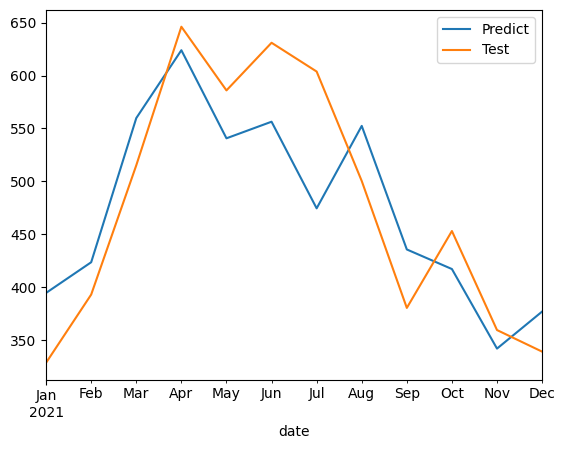

In [187]:
forecaster.predict(steps=12).plot(label='Predict')
monthly.query("year==2021")['sumgsr'].plot(label='Test')
plt.legend()
plt.show()

In [188]:
pred = forecaster.predict(steps=12)
y_test = monthly.query("year==2021")['sumgsr']

r2_score(y_test, pred)

0.7345621519426817

# Calc Power Production
- sumGsr (MJ/m^2)
- Wh = J / 3600
- Daily Power Production = (sumGsr\ x 10^6) / 3600 x (Area) x (efficiency - other causes)

In [190]:
# with open('model.pkl', 'wb') as pickle_file:
#     pickle.dump(forecaster, pickle_file)

In [2]:
import pickle

In [3]:
with open('model.pkl', 'rb') as pickle_file:
    model = pickle.load(pickle_file)

month = 12
generate = model.predict(steps=month)
generate_power = generate/3600*1000*20*0.15

In [13]:
def calc_payment(power_use):
    if month in [7, 8]:
        if power_use <= 300:
            payment = 910 + power_use*100.6
        elif power_use <= 450:
            payment = 1600 + 300*100.6 + (power_use-300)*195.2
        elif power_use <= 1000:
            payment = 7300 + 300*100.6 + 150*195.2 + (power_use-450)*287.9
        else:
            payment = 7300 + 300*100.6 + 150*195.2 + 550*287.9 + (power_use-1000)*716.8

    else:
        if power_use <= 200:
            payment = 910 + power_use*100.6
        elif power_use <= 400:
            payment = 1600 + 200*100.6 + (power_use-200)*195.2
        else:
            if month in [1, 2, 12]:
                if power_use <= 1000:
                    payment = 7300 + 200*100.6 + 200*195.2 + (power_use-400)*287.9
                else:
                    payment = 7300 + 200*100.6 + 200*195.2 + 600*287.9 + (power_use-1000)*716.8
            else:
                payment = 7300 + 200*100.6 + 200*195.2 + (power_use-400)*287.9

    total_payment = ((payment + power_use*7.30) * 1.137) // 10 * 10

    return total_payment

In [14]:
current_power_use = int(input())
reduced_power_use = current_power_use - generate_power[month-1]

current_payment = calc_payment(current_power_use)
reduced_payment = calc_payment(reduced_power_use)

if reduced_power_use <= 1150:
    saved_money = 1150
else:
    saved_money = current_payment - reduced_payment

print(f"Saved money: {saved_money}")

Saved money: 213760.0


정부 지원금: 860,000/kW -> 3kW: 258만
사업비 상한액: 516만

※산업통상자원부 공고 제 2022-369호